In [89]:
import numpy as np
import pandas as pd
from numpy import newaxis as na
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_auc_score
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,SimpleRNN,LSTM,Activation,Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [90]:
df_all_scaled = pd.read_csv('cleaned_set-a.csv',index_col=0)

#ndarrayに変形
data = np.zeros((1,4,41)) #for文に入れるの初期値
for i in range(4000):
    array = df_all_scaled.iloc[i*4:(i+1)*4,:].values.reshape(1,4,41)
    data = np.concatenate([data,array],axis=0)
data = np.delete(data,obj=0,axis=0) #初期値として入れていた行を削除

# 観測の長さの違いを再現。最初の1000件は24時間までのデータを0に変更
data[0:1000,0:2,:] = 0

#ターゲットデータの作成
outcome = pd.read_csv('Outcomes-a.txt')
outcome.head()

target = outcome['In-hospital_death'].values

print('data.shape:',data.shape)
print('target.shape:',target.shape)

data.shape: (4000, 4, 41)
target.shape: (4000,)


In [91]:
#乱数の固定
import random as rn
np.random.seed(42)

rn.seed(12345)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                                        inter_op_parallelism_threads=1)

tf.compat.v1.set_random_seed(1234)

sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)


In [92]:
x_train,x_test,y_train,y_test = train_test_split(data,target,shuffle=True,test_size=0.2)

In [93]:
input_tensor = Input(shape=data.shape[1:])
RNN_output = SimpleRNN(100,activation='tanh',return_sequences=True,dropout=0.5,recurrent_dropout=0.2)(input_tensor)
x = Dense(100,activation='relu')(RNN_output[:,-1,:])
x = Dense(1)(x)
output_tensor = Activation('sigmoid')(x)
model = Model(input_tensor,output_tensor)

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4, 41)]           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 4, 100)            14200     
_________________________________________________________________
tf_op_layer_strided_slice_2  [(None, 100)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 24,401
Trainable params: 24,401
Non-trainable params: 0
_______________________________________________________

In [94]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['AUC'])

es = EarlyStopping(monitor='val_loss',patience=30,verbose=1)
hist = model.fit(x_train,y_train,
                 epochs=200,batch_size=256,
                 verbose=2,
                 validation_data=(x_test,y_test),
                 callbacks=[es])

Train on 3200 samples, validate on 800 samples
Epoch 1/2000
3200/3200 - 2s - loss: 0.4726 - AUC: 0.6003 - val_loss: 0.3965 - val_AUC: 0.7105
Epoch 2/2000
3200/3200 - 0s - loss: 0.3707 - AUC: 0.6950 - val_loss: 0.3638 - val_AUC: 0.7630
Epoch 3/2000
3200/3200 - 0s - loss: 0.3505 - AUC: 0.7424 - val_loss: 0.3501 - val_AUC: 0.7854
Epoch 4/2000
3200/3200 - 0s - loss: 0.3425 - AUC: 0.7596 - val_loss: 0.3430 - val_AUC: 0.7975
Epoch 5/2000
3200/3200 - 0s - loss: 0.3329 - AUC: 0.7820 - val_loss: 0.3348 - val_AUC: 0.8083
Epoch 6/2000
3200/3200 - 0s - loss: 0.3369 - AUC: 0.7739 - val_loss: 0.3317 - val_AUC: 0.8130
Epoch 7/2000
3200/3200 - 0s - loss: 0.3323 - AUC: 0.7807 - val_loss: 0.3322 - val_AUC: 0.8126
Epoch 8/2000
3200/3200 - 0s - loss: 0.3299 - AUC: 0.7852 - val_loss: 0.3296 - val_AUC: 0.8164
Epoch 9/2000
3200/3200 - 0s - loss: 0.3359 - AUC: 0.7732 - val_loss: 0.3277 - val_AUC: 0.8209
Epoch 10/2000
3200/3200 - 0s - loss: 0.3336 - AUC: 0.7788 - val_loss: 0.3260 - val_AUC: 0.8223
Epoch 11/200

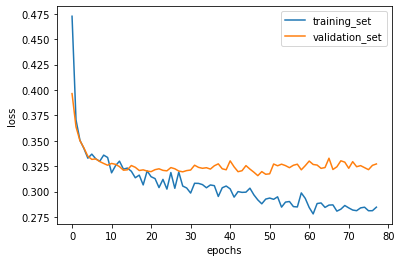

In [95]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(range(len(loss)),loss,label='training_set')
plt.plot(range(len(val_loss)),val_loss,label='validation_set')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

# LRPの実装

貢献スコアは各層の出入力値、各層の活性化前の値、各層の重みとバイアスが取得できれば計算できる

In [23]:
def linear_LRP(input_arr,w,b,preactivation,R_upper,eps=0.01):
    """
    N = サンプル数（バッチ数）
    M = この層のニューロン数
    D = 下の層のニューロン数
    input.shape = (N,D)
    w.shape = (D,M)
    b.shape = (M,)
    R_upper.shape = (N,M)
    pre_activation = np.dot(input,w) + b    # shape(N,M)
    """
    
    sign_preact = np.where(preactivation>=0,1,-1)  #shape(N,M)
    
    numer = w*input_arr[:,:,np.newaxis]      # shape(N,D,M)
    denom    = preactivation[:,np.newaxis,:] + (eps*sign_preact[:,np.newaxis,:])   # shape (N,1, M)
    
    message = (numer/denom)*R_upper[:,np.newaxis,:]
    
    R_lower = np.sum(message,axis=2)
    
    return R_lower  # shape(N,D)

In [24]:
def RNN_LRP(input_arr,w,u,b,R_upper,output):
    '''
    input.shape = (N,T,dim)
    output.shape = (N,T,units)
    '''
    
    R_in = np.zeros(input_arr.shape)
    for i in np.arange(1,input_arr.shape[1])[::-1]: #[3,2,1]
        preactivation = np.dot(input_arr[:,i,:],w)+np.dot(output[:,i-1,:],u)+b
        
        R_in[:,i,:] = linear_LRP(input_arr[:,i,:],w,b,preactivation,R_upper)
       # from IPython.core.debugger import Pdb; Pdb().set_trace()
        R_upper = linear_LRP(output[:,i-1,:],u,b,preactivation,R_upper)

    preactivation = np.dot(input_arr[:,0,:],w)+b
    R_in[:,0,:] = linear_LRP(input_arr[:,0,:],w,b,preactivation,R_upper)
    
    return R_in

In [25]:
model.layers

In [26]:
layers = [l for l in model.layers if isinstance(l,(Dense,SimpleRNN))]

In [27]:
layers_name = [l.name for l in layers]
layers_weights = [l.get_weights() for l in layers]

outputs = [model.get_layer(l_name).output for l_name in layers_name]
inputs = [model.get_layer(l_name).input for l_name in layers_name]

get_output_model = Model(inputs=model.input,outputs=outputs)
get_input_model = Model(inputs=model.input,outputs=inputs)
                                 

In [31]:
layer_outputs = get_output_model.predict(x_test)  #!!!! X_test
layer_inputs = get_input_model.predict(x_test)
R_upper = layer_outputs[-1]

for layer,i in zip(layers[::-1],np.arange(0,len(layers))[::-1]):
    if isinstance(layer,Dense):
        input_arr = layer_inputs[i]
        w = layers_weights[i][0]
        b = layers_weights[i][1]
        preactivation = np.dot(input_arr,w)+b
        R_lower = linear_LRP(input_arr,w,b,preactivation,R_upper)
        R_upper = R_lower
        
        continue

    if isinstance(layer,SimpleRNN):
        input_arr = layer_inputs[i]    
        w = layers_weights[i][0]
        u = layers_weights[i][1]
        b = layers_weights[i][2]
        outputs = layer_outputs[i]
        R_in = RNN_LRP(input_arr,w,u,b,R_upper,outputs)

predict score: [[0.70818466]]
target: 1


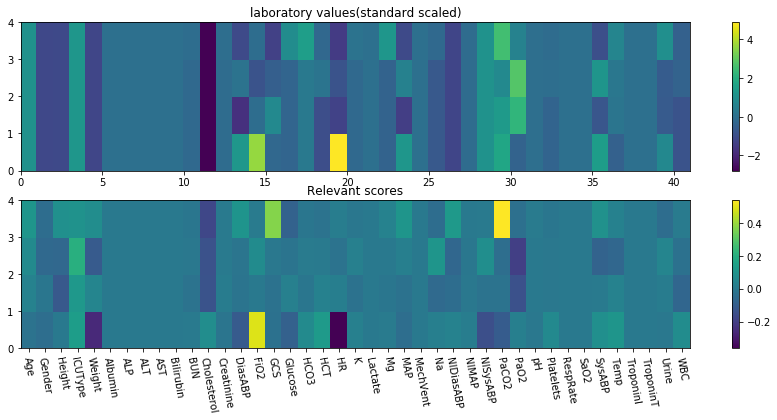

In [105]:
dead_id = np.where(y_test==1)[0]
k= dead_id[28]

print('predict score:',model.predict(x_test[k:k+1,:,:]))
print('target:',y_test[k])


fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(2,1,1)
real_value = ax1.pcolor(x_test[k])
ax1.set_title('laboratory values(standard scaled)')

ax2 = fig.add_subplot(2,1,2)
heatmap = ax2.pcolor(R_in[k,:,:])
ax2.set_xticks(0.5+np.arange(len(df_all_scaled.columns.values)))
ax2.set_xticklabels(df_all_scaled.columns.values,rotation=-80)
ax2.set_title('Relevant scores')

fig.colorbar(real_value,ax=ax1)
fig.colorbar(heatmap,ax=ax2)
plt.show()

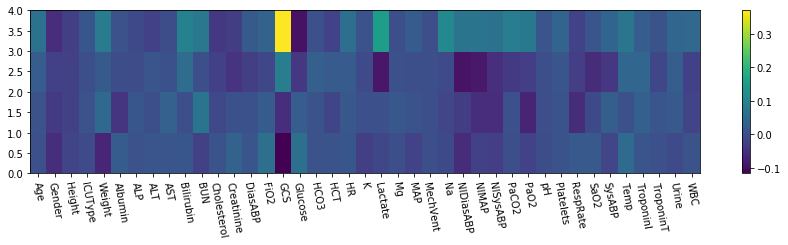

In [73]:
#Rの絶対値を患者ごとに平均。どこをモデルが重視しているか可視化
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(1,1,1)

heatmap = ax.pcolor(np.average(R_in[dead_id],axis=0))

ax.set_xticks(0.5+np.arange(len(df_all_scaled.columns.values)))
ax.set_xticklabels(df_all_scaled.columns.values,rotation=-80)
fig.colorbar(heatmap,ax=ax)
plt.show()

<BarContainer object of 4 artists>

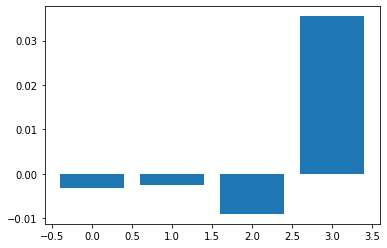

In [74]:
#時間経過とR絶対値の関係
plt.bar(range(4),np.average(np.average(R_in[dead_id],axis=2),axis=0))

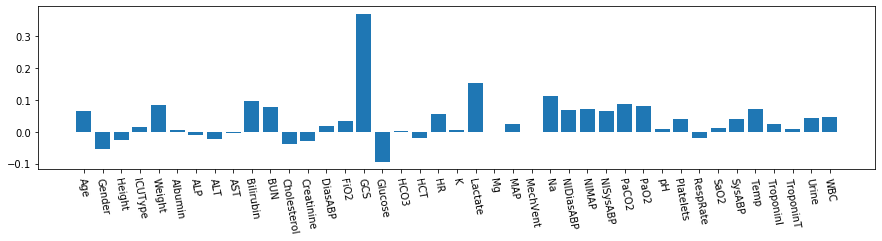

In [109]:
#項目とR絶対値の関係
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(1,1,1)

ax.bar(range(R_in.shape[2]),np.average(R_in[dead_id,3],axis=0))
ax.set_xticks(np.arange(len(df_all_scaled.columns.values)))
ax.set_xticklabels(df_all_scaled.columns.values,rotation=-80)

plt.show()

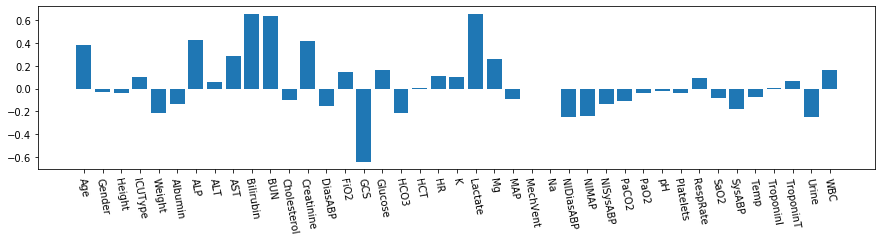

In [88]:
#項目とR絶対値の関係
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(1,1,1)

ax.bar(range(R_in.shape[2]),np.average(np.average(x_test[dead_id],axis=1),axis=0))
ax.set_xticks(np.arange(len(df_all_scaled.columns.values)))
ax.set_xticklabels(df_all_scaled.columns.values,rotation=-80)

plt.show()

# Sensitivity　Analysis

In [39]:
from keras import backend as K #tf.kerasだとGradientTapeを使えといわれる

#入力に対する出力の勾配を計算
grads = K.gradients(model.output, model.input)[0]
gradient_function = K.function(model.input,grads)

grads_val = gradient_function(x_test)

Using TensorFlow backend.


In [40]:
grads_val.shape

(800, 4, 41)

predict score: [[0.03782566]]
target: 1


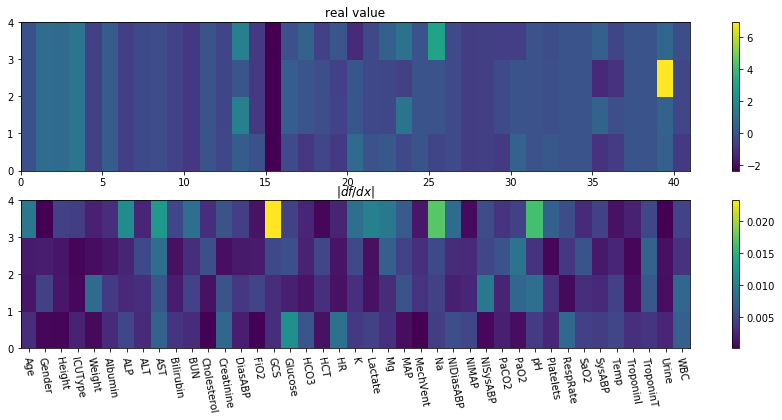

In [57]:
k=5

print('predict score:',model.predict(x_test[k:k+1,:,:]))
print('target:',y_test[k])


fig = plt.figure(figsize=(15,6))

ax1 = fig.add_subplot(2,1,1)
real_value = ax1.pcolor(x_test[k])
ax1.set_title('real value')

ax2 = fig.add_subplot(2,1,2)
heatmap = ax2.pcolor(np.absolute(grads_val[k,:,:]))
ax2.set_xticks(0.5+np.arange(len(df_all_scaled.columns.values)))
ax2.set_xticklabels(df_all_scaled.columns.values,rotation=-80)
ax2.set_title('$|df/dx|$')

fig.colorbar(real_value,ax=ax1)
fig.colorbar(heatmap,ax=ax2)
plt.show()

よくわかんないけど、出力に対する入力の勾配が計算できているっぽい  
入力が０でマスクしてあるところにも勾配が生じている。確かにそこに値が入れば出力は大きく変わるだろうから、勾配が大きいのは妥当であろう

<BarContainer object of 4 artists>

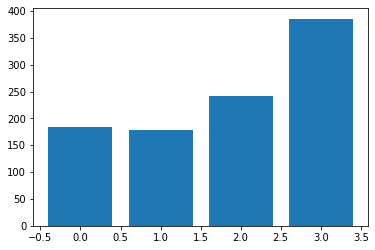

In [58]:
plt.bar(range(4),np.sum(np.sum(np.absolute(grads_val),axis=0),axis=1))

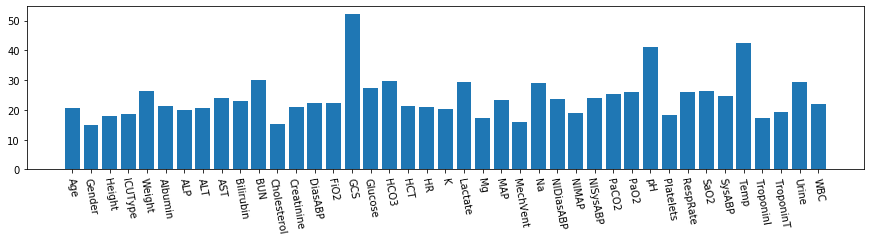

In [59]:
fig = plt.figure(figsize=(15,3))
ax = fig.add_subplot(1,1,1)

ax.bar(range(grads_val.shape[2]),np.sum(np.sum(np.absolute(grads_val),axis=0),axis=0))
ax.set_xticks(np.arange(len(df_all_scaled.columns.values)))
ax.set_xticklabels(df_all_scaled.columns.values,rotation=-80)

plt.show()